In [1]:
#Choose GPUs and CPUs

#If want to choose GPU to use
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1,4"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist


GPU=True
CPU=False
num_cores = 4

if GPU:
    num_GPU = 2
    num_CPU = 1
if CPU:
    num_CPU = 1
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
session = tf.Session(config=config)
K.set_session(session)
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import Model
from keras.utils import multi_gpu_model


class ModelMGPU(Model):
    def __init__(self, ser_model, gpus):
        pmodel = multi_gpu_model(ser_model, gpus)
        self.__dict__.update(pmodel.__dict__)
        self._smodel = ser_model

    def __getattribute__(self, attrname):
        '''Override load and save methods to be used from the serial-model. The
        serial-model holds references to the weights in the multi-gpu model.
        '''
        # return Model.__getattribute__(self, attrname)
        if 'load' in attrname or 'save' in attrname:
            return getattr(self._smodel, attrname)

        return super(ModelMGPU, self).__getattribute__(attrname)

# Load MNIST data from Keras

In [3]:

# input image dimensions
img_rows, img_cols = 28, 28
num_classes=10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_dataset = x_train.astype('float32')
test_dataset = x_test.astype('float32')
train_dataset /= 255
test_dataset /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)


train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# FT the training and test data

In [4]:
from scipy.fftpack import fftn,fftshift
dims=train_dataset.shape
ft_train=[]
for i in range(dims[0]):
    ft_train.append(np.abs(fftshift(fftn(train_dataset[i,:,:]))))

dims=test_dataset.shape
ft_test=[]
for i in range(dims[0]):
    ft_test.append(np.abs(fftshift(fftn(test_dataset[i,:,:])))) #Don't forget to take abs!

ft_train=np.asarray(ft_train)
ft_test=np.asarray(ft_test)
print (ft_train.shape)
print (ft_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


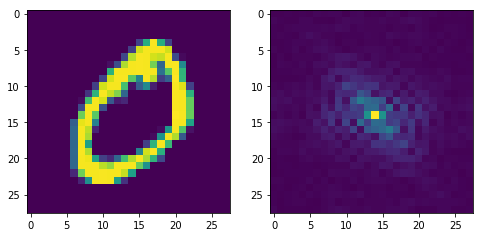

In [5]:
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(train_dataset[1].squeeze())
axarr[1].imshow(ft_train[1].squeeze())

# O.K now try CNN

In [29]:
dims=ft_train.shape
print (dims)
trainee=ft_train.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=ft_test.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)


from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.utils import to_categorical

K.clear_session()
np.random.seed(123)
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1),data_format='channels_last'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

parallel_model = ModelMGPU(model, gpus=num_GPU)
parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print (model.summary())
print (parallel_model.summary())



checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(trainee, train_labels, batch_size=256, verbose=1, epochs=10, validation_split = 0.1, callbacks=[checkpoints])

(60000, 28, 28, 1)
(60000, 28, 28, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10

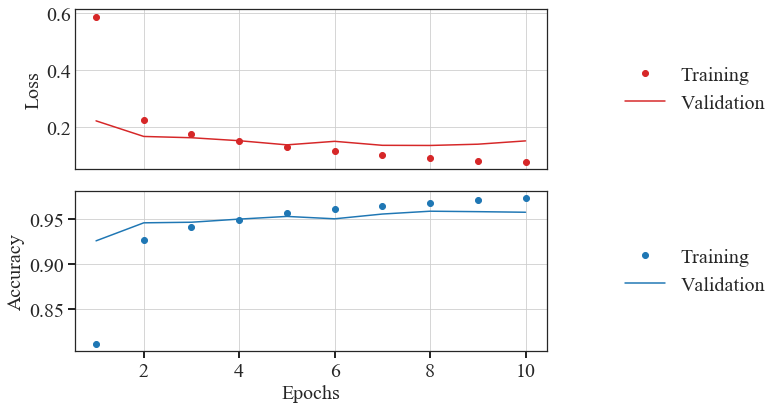

In [30]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

In [31]:
from keras.models import Model, load_model
model=load_model('tmp_models/weights.08.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

10000/10000 [==============================] - 1s 143us/step
[0.14821517372876405, 0.95540000000000003]


In [32]:
preds=(model.predict(testee))

6


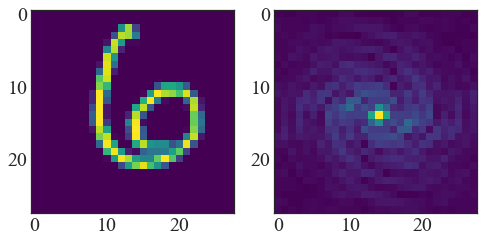

In [38]:
i=100
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(test_dataset[i].squeeze(),cmap='viridis')
axarr[1].imshow(testee[i].squeeze(), cmap='viridis')
print (np.argmax(preds[i]))